#### Checklist
##### Cleaning
- [] check unique values for each columns  
- [] remove oulier (percentile)  
- [] remove unused columns  
- [] check empty, none, nan values, white spaces (regex)  

##### Additional datas
- [] add province and zip code (external csv datas)  


#### Questions

- percentage of houses by provinces within a budget  
- price per sq meters by price  
- 
- graph heatmap over belgium (price/sqmeter)  


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import geopandas as gpd
#_____________________________________________________________________________

from scripts.colors import bcolors as bc

In [4]:
file = './datas/Immoweb_data_ok_maite.csv'
data = pd.read_csv(file)
data.head()

,Id,Locality,House or appartment?,Subtype,Price,Type of sale,Number of rooms,Living area,Fully equipped kitchen,Furnished,Open fire,Terrace,Area of terrace,Garden,Area of garden,Land surface,Number of facades,Swimming pool,State of building
0,10233388,Uccle,HOUSE,HOUSE,1295000.0,BUY_REGULAR,4.0,290.0,1,None,0,1,15,None,None,230,2,0,GOOD
1,10311296,Woluwe-Saint-Pierre,APARTMENT,APARTMENT,150000.0,PUBLIC_SALE,2.0,65.0,0,None,0,1,None,None,None,None,None,None,None
2,10310451,Anderlecht,APARTMENT,APARTMENT,357500.0,BUY_REGULAR,3.0,119.0,0,None,0,1,16,None,None,None,4,None,NaN
3,10309870,Uccle,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2.0,140.0,0,None,0,None,None,None,None,None,2,None,TO_BE_DONE_UP
4,10309546,Uccle,APARTMENT,APARTMENT,199000.0,BUY_REGULAR,1.0,61.0,0,None,0,1,2,None,None,None,2,None,NaN


1. Check for duplicated rows in the df

In [5]:
data.duplicated()

# data_duplicated = data[data.duplicated(subset='Id') == True]
# data_duplicated.head(15)
data.isnull().sum()

Id                           0
Locality                     0
House or appartment?         0
Subtype                      0
Price                     7106
Type of sale                 0
Number of rooms            116
Living area               3235
Fully equipped kitchen       0
Furnished                    0
Open fire                    0
Terrace                      0
Area of terrace              0
Garden                       0
Area of garden               0
Land surface              4424
Number of facades         6696
Swimming pool                0
State of building         7343
dtype: int64

### Cleaning data



In [6]:
data.replace(np.NaN,'None', inplace=True)
data.replace('None', pd.NA, inplace=True)
data.head()
data = data.drop(data[data['Price'].isna()].index)
data.shape[0]
# data.head()
# data.drop_duplicates('Id')
# data.duplicated().value_counts()

16280

2. Remove data from apartment_group and house_group

In [7]:
data[data['House or appartment?'] == 'APARTMENT_GROUP'].count()
data.drop(data[data['House or appartment?'] == 'APARTMENT_GROUP'].index, inplace=True)
data[data['House or appartment?'] == 'HOUSE_GROUP'].count()
data.drop(data[data['House or appartment?'] == 'HOUSE_GROUP'].index, inplace=True)


In [8]:
data['House or appartment?'].unique()

array(['HOUSE', 'APARTMENT'], dtype=object)

3. Check subtype

In [9]:
data[data['Subtype'] == 'APARTMENT_GROUP'].count()
data.drop(data[data['Subtype'] == 'APARTMENT_GROUP'].index, inplace=True)
data[data['Subtype'] == 'HOUSE_GROUP'].count()
data.drop(data[data['Subtype'] == 'HOUSE_GROUP'].index, inplace=True)


In [10]:
data['Number of rooms'].unique()
data['Number of rooms'].describe([.7,.8,.9,.99])

count     16280.0
unique       28.0
top           2.0
freq       5251.0
Name: Number of rooms, dtype: float64

### Add new columns
    -price sq meter

In [30]:
data['price_square_meters'] = (data['Price'] / data['Living area'])
data['price_square_meters'] = pd.to_numeric(data['price_square_meters'], errors='coerce')

# data = data.drop(data['price_square_meters'].isna().index)
# # data.drop(data[data['price_square_meters'].isnull()].index)
# # data['price_square_meters'].round(2)
data.head()
# data.head()

,Id,Locality,House or appartment?,Subtype,Price,Type of sale,Number of rooms,Living area,Fully equipped kitchen,Furnished,Open fire,Terrace,Area of terrace,Garden,Area of garden,Land surface,Number of facades,Swimming pool,State of building,price_square_meters
1,10311296,Woluwe-Saint-Pierre,APARTMENT,APARTMENT,150000.0,PUBLIC_SALE,2.0,65.0,0,<NA>,0,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2307.692308
2,10310451,Anderlecht,APARTMENT,APARTMENT,357500.0,BUY_REGULAR,3.0,119.0,0,<NA>,0,1,16,<NA>,<NA>,<NA>,4,<NA>,<NA>,3004.201681
3,10309870,Uccle,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2.0,140.0,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,TO_BE_DONE_UP,2107.142857
4,10309546,Uccle,APARTMENT,APARTMENT,199000.0,BUY_REGULAR,1.0,61.0,0,<NA>,0,1,2,<NA>,<NA>,<NA>,2,<NA>,<NA>,3262.295082
5,10308639,Berchem-Sainte-Agathe,HOUSE,HOUSE,485000.0,BUY_REGULAR,3.0,235.0,0,<NA>,0,<NA>,<NA>,1,100,200,2,0,TO_BE_DONE_UP,2063.829787


KeyError: 'PENTHOUSE'

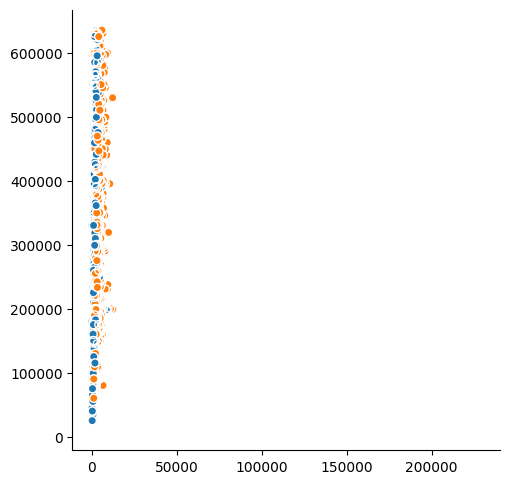

In [38]:
data = data.drop(data[data['Living area'].isna()].index)
data = data.drop(data[data['price_square_meters'].isna()].index)
data['price_square_meters'].isnull().sum()
q1 , q3 = data['Price'].quantile([0.25,0.75])
iqr = q3 - q1
# print(q1,q3)

data = data[(data['Price'] > (q1 - 1.5*iqr)) & (data['Price'] < ((q3 + 1.5*iqr)))]
data = data[(data['price_square_meters'] > (q1 - 1.5*iqr)) & (data['price_square_meters'] < ((q3 + 1.5*iqr)))]
# data['Living area'].dtypes
# data['price_square_meters'].dtypes
g_price = sns.relplot(x="price_square_meters", y='Price',hue='Subtype',hue_order=['HOUSE','APARTMENT'],kind='scatter', style="Subtype", style_order=['HOUSE','APARTMENT'],  data=data)
g_price.set(xlim=(0,10000))



TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

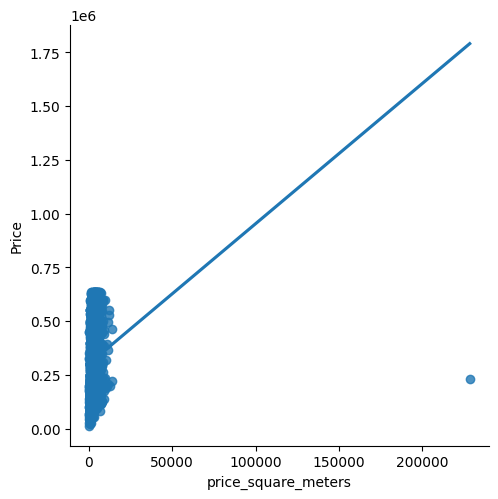

In [37]:
data['price_square_meters'].isna().sum()
g_price_linearreg = sns.lmplot(x="price_square_meters", y='Price',  data=data)
print(type(g_price_linearreg))
plt.xlim(0,10000)
plt.show()

# check pricesq meter is float64
#  TBD: Quantile for the two datas, in a function

#  Do a boxplot of ap and houses price, mean, iqr,std, outliers


### Check price, remove outliers

In [ ]:
data['Price'].describe()
data['Price'].shape[0]
q1 , q3 = data['Price'].quantile([0.25,0.75])
iqr = q3 - q1
print(q1,q3)

data_Price = data[(data['Price'] > (q1 - 1.5*iqr)) & (data['Price'] < ((q3 + 1.5*iqr)))]
data_Price.shape[0]

data_Price.describe()


239950.0 450000.0


,Id,Open fire
count,1.495700e+04,14957.000000
mean,1.010086e+07,0.039446
std,3.651118e+05,0.194661
min,1.882546e+06,0.000000
25%,1.009175e+07,0.000000
50%,1.023038e+07,0.000000
75%,1.028632e+07,0.000000
max,1.031627e+07,1.000000


#### Remove empty values, 

In [ ]:

data_Price.loc[:,'square_meter_price'] = data_Price.loc[:,'Price'] / data_Price.loc[:,'Living area']


data_Price.dtypes


C:\Users\meule\AppData\Local\Temp\ipykernel_7196\3914038560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Price.loc[:,'square_meter_price'] = data_Price.loc[:,'Price'] / data_Price.loc[:,'Living area']


Id                         int64
Locality                  object
House or appartment?      object
Subtype                   object
Price                     object
Type of sale              object
Number of rooms           object
Living area               object
Fully equipped kitchen    object
Furnished                 object
Open fire                  int64
Terrace                   object
Area of terrace           object
Garden                    object
Area of garden            object
Land surface              object
Number of facades         object
Swimming pool             object
State of building         object
price_square_meters       object
square_meter_price        object
dtype: object